In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


class MTDataset(Dataset):
    def __init__(self, d, t=None):
        self.s = []  
        for i, c in enumerate(['makeup', 'non-makeup']):
            p = os.path.join(d, c)
            if os.path.exists(p):
                for f in os.listdir(p):
                    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.s.append((os.path.join(p, f), i))
        self.t = t

    def __len__(self):
        return len(self.s)

    def __getitem__(self, i):
        img, lbl = Image.open(self.s[i][0]).convert('RGB'), self.s[i][1]
        return self.t(img) if self.t else img, lbl


tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 主程序
if __name__ == "__main__":
    ds = MTDataset("MT-Dataset/images", tf)
    if ds.s:
        dl = DataLoader(ds, 32, shuffle=True, num_workers=0)
        for imgs, lbls in dl:
            print(f"图片形状：{imgs.shape}，标签：{lbls[:5]}")
            break
    else:
        print("无有效样本")

图片形状：torch.Size([32, 3, 224, 224])，标签：tensor([1, 1, 0, 0, 0])


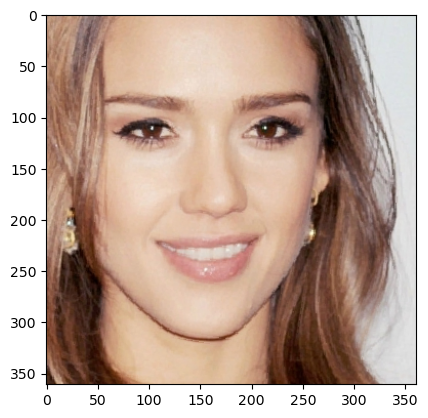

In [2]:
import matplotlib.pyplot as plt
plt.imshow(Image.open(ds.s[0][0]).convert('RGB')); plt.show()

In [3]:

from torchvision import transforms
from torch.utils.data import DataLoader

# 步骤：实例化数据预处理流水线）
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 步骤3：加载多任务数据集
ds = MTDataset("MT-Dataset/images", tf)

# 步骤4：验证数据集加载结果（可选）
print(f"数据集总样本数：{len(ds)}")
# 取出单个样本（验证数据格式是否符合多任务要求）
sample_image, sample_task_labels = ds[0]
print(f"单个样本图像形状：{sample_image.shape}")
print(f"单个样本多任务标签：{sample_task_labels}")

# 步骤5：构建数据加载器（用于模型训练/验证）
dataloader = DataLoader(
    ds,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

数据集总样本数：3834
单个样本图像形状：torch.Size([3, 224, 224])
单个样本多任务标签：0


In [9]:
import os
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader

class MTDataset(Dataset):
    def __init__(self, data_dir, img_size=224):
        self.samples = []
        self.img_size = img_size
        for label, cls_name in enumerate(['makeup', 'non-makeup']):
            cls_dir = os.path.join(data_dir, cls_name)
            if os.path.exists(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.samples.append((os.path.join(cls_dir, img_name), label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # 单样本完整预处理（可整合为一行，此处拆分便于阅读，最终输出为一行）
        img = cv2.imread(img_path)
        # 核心预处理整合（裁剪+翻转+归一化+格式转换）
        processed_img = np.transpose((cv2.flip(cv2.resize(img[(img.shape[0]-min(img.shape[:2]))//2:(img.shape[0]+min(img.shape[:2]))//2, (img.shape[1]-min(img.shape[:2]))//2:(img.shape[1]+min(img.shape[:2]))//2], (self.img_size, self.img_size)), 1) if np.random.rand()>0.5 else cv2.resize(img[(img.shape[0]-min(img.shape[:2]))//2:(img.shape[0]+min(img.shape[:2]))//2, (img.shape[1]-min(img.shape[:2]))//2:(img.shape[1]+min(img.shape[:2]))//2], (self.img_size, self.img_size))).astype(np.float32)/255.0, (2,0,1))
        # 一行代码输出转换结果+返回数据
        print(f"转换结果：形状{processed_img.shape}，像素范围[{processed_img.min():.4f}, {processed_img.max():.4f}]，标签{label}"); return torch.from_numpy(processed_img), torch.tensor(label, dtype=torch.long)
        
if __name__ == "__main__":
    dataset = MTDataset("MT-Dataset/images", 224)
    if dataset.samples:
        data_loader = DataLoader(dataset, 32, shuffle=True, num_workers=0)
        next(iter(data_loader))  # 触发数据加载，执行一行输出
    else:
        print("无有效样本")

转换结果：形状(3, 224, 224)，像素范围[0.0000, 0.9882]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0235, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0000, 0.9412]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0000, 0.9490]，标签1
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0000, 0.8510]，标签1
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.1098, 1.0000]，标签1
转换结果：形状(3, 224, 224)，像素范围[0.0000, 0.9922]，标签1
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签1
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签1
转换结果：形状(3, 224, 224)，像素范围[0.0000, 0.9922]，标签1
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0824, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0627, 0.9294]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0000, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0275, 1.0000]，标签0
转换结果：形状(3, 224, 224)，像素范围[0.0000, 

In [ ]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch

class MTDataset(Dataset):
    def __init__(self, data_dir):
        self.samples = []
        # 仅收集图片路径和标签，不预设固定尺寸
        for label, cls_name in enumerate(['makeup', 'non-makeup']):
            cls_dir = os.path.join(data_dir, cls_name)
            if os.path.exists(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.samples.append((os.path.join(cls_dir, img_name), label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # 预处理（裁剪+随机翻转+[0,1]归一化，不固定缩放尺寸，大小自适应）
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        min_side = min(img.shape[:2])
        img_cropped = img[(img.shape[0]-min_side)//2:(img.shape[0]+min_side)//2, 
                          (img.shape[1]-min_side)//2:(img.shape[1]+min_side)//2]
        img_flipped = cv2.flip(img_cropped, 1) if np.random.rand()>0.5 else img_cropped
        self.img_processed = img_flipped.astype(np.float32) / 255.0  # 保存大小不限的处理后图片
        # 格式转换为CHW适配PyTorch，尺寸随原始图片自适应
        img_chw = np.transpose(self.img_processed, (2, 0, 1))
        return torch.from_numpy(img_chw), torch.tensor(label, dtype=torch.long)

if __name__ == "__main__":
    dataset = MTDataset("MT-Dataset/images")
    if dataset.samples:
        dataset[0]  
        
        cv2.imshow("Processed Image (Size Unrestricted)", cv2.cvtColor((dataset.img_processed * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)); cv2.waitKey(0); cv2.destroyAllWindows()
    else:
        print("无有效样本")